<a href="https://colab.research.google.com/github/fadillarizalul/thesis-alzheimer/blob/main/model_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# set up dan init

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

In [3]:
import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

#import data dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget --no-check-certificate \
https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients-train-test.zip \
  -O 3-classes-alzheimer-20-patients-train-test.zip

--2022-10-15 06:50:27--  https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients-train-test.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients-train-test.zip [following]
--2022-10-15 06:50:27--  https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients-train-test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11768361 (11M) [application/zip]
Saving to: ‘3-classes-alzheimer-20-patients-train-test.zip’

3-classes-alzheim

In [6]:
!unzip /content/3-classes-alzheimer-20-patients-train-test.zip

Archive:  /content/3-classes-alzheimer-20-patients-train-test.zip
   creating: 3-classes-alzheimer-20-patients/
   creating: 3-classes-alzheimer-20-patients/test/
  inflating: 3-classes-alzheimer-20-patients/test/img-00001-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00001-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00001-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00001-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00001-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00002-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00002-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00002-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00002-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00002-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/test/img-00003-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/

In [7]:
import os
 #lokasi direktori dasar
dir_base ='/content/3-classes-alzheimer-20-patients/train'
os.listdir(dir_base)
print(os.listdir(dir_base))

#hitung jumlah file per direktori
data_cn = len(os.listdir('/content/3-classes-alzheimer-20-patients/train/CN'))
data_mci = len(os.listdir('/content/3-classes-alzheimer-20-patients/train/MCI')) 
data_ad = len(os.listdir('/content/3-classes-alzheimer-20-patients/train/AD')) 

print("Amount of CN class images:", data_cn)
print("Amount of MCI class images:", data_mci)
print("Amount of AD class images:", data_ad)

['CN', 'AD', 'MCI']
Amount of CN class images: 101
Amount of MCI class images: 100
Amount of AD class images: 108


# Data Generation and Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2
                                   )

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    directory = dir_base,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
    subset='training'
)
 
val_generator = train_datagen.flow_from_directory(
    directory = dir_base,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'categorical',
    subset='validation'
)

Found 248 images belonging to 3 classes.
Found 61 images belonging to 3 classes.


In [16]:
# fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

# import tqdm
# from tqdm import tqdm

# for i in tqdm(range(0,5)):
#     rand1 = np.random.randint(len(train_generator))
#     rand2 = np.random.randint(100)
#     ax[i].imshow(train_generator[rand1][0][rand2])
#     ax[i].axis('off')
#     a = train_generator[rand1][1][rand2]
#     if a[0] == 1:
#         ax[i].set_title('CN')
#     elif a[1] == 1:
#         ax[i].set_title('MCI')
#     elif a[2] == 1:
#         ax[i].set_title('AD')

In [17]:
# # TRAIN
# image_gen_train = ImageDataGenerator(rescale=1./255., 
#                                      horizontal_flip=True, 
#                                      rotation_range=20, 
#                                      zoom_range=0.2)

# train_generator = image_gen_train.flow_from_directory(
#     train,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

In [18]:
# # VALID
# image_gen_val = ImageDataGenerator(rescale=1./255.)

# val_generator = image_gen_val.flow_from_directory(
#     val,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

In [19]:
# # TEST
# image_gen_test = ImageDataGenerator(rescale=1./255.)

# test_generator = image_gen_val.flow_from_directory(
#     test,
#     directory = dir_base,
#     target_size = (IMG_SHAPE,IMG_SHAPE),
#     batch_size = BATCH_SIZE,
#     class_mode = 'categorical'
# )

# Create CNN model

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_tensor=Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [22]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [23]:
base_model.trainable = False

In [24]:
head = base_model.output

head = MaxPooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)

# head = Dense(128, activation='elu')(head)
# head = Dropout(0.3)(head)

head = Dense(256, activation='elu')(head)
head = Dropout(0.3)(head)

head = Dense(3, activation='softmax')(head)

model = Model(base_model.input, head)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Compile the Model

In [27]:
# Model Compile 
import tensorflow 

OPT = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              #metrics=['accuracy'],
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


early stopping

In [28]:
# # Earlystopping will stop the learning process when there are no
# # ten consecutive improvements in the val_loss.
# earlystopping = EarlyStopping(monitor='val_loss', 
#                               mode='min',
#                               verbose=1,
#                               patience=15)


# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               mode='min',
#                               verbose=1,
#                               patience=5,
#                               min_delta=0.0001,
#                               factor=0.2)

In [29]:
history = model.fit(train_generator, 
                    epochs=25, 
                    validation_data=val_generator, 
                    )

Epoch 1/25
8/8 [==============================] - 18s 888ms/step - loss: 12.2633 - auc: 0.4587 - val_loss: 3.2236 - val_auc: 0.4802
Epoch 2/25
8/8 [==============================] - 5s 576ms/step - loss: 2.9265 - auc: 0.4907 - val_loss: 2.2463 - val_auc: 0.4153
Epoch 3/25
8/8 [==============================] - 5s 573ms/step - loss: 2.1929 - auc: 0.4501 - val_loss: 1.3401 - val_auc: 0.4150
Epoch 4/25
8/8 [==============================] - 5s 574ms/step - loss: 1.4356 - auc: 0.5297 - val_loss: 1.2275 - val_auc: 0.4013
Epoch 5/25
8/8 [==============================] - 5s 577ms/step - loss: 1.3542 - auc: 0.5250 - val_loss: 1.2005 - val_auc: 0.4311
Epoch 6/25
8/8 [==============================] - 5s 638ms/step - loss: 1.3873 - auc: 0.5100 - val_loss: 1.1752 - val_auc: 0.3952
Epoch 7/25
8/8 [==============================] - 6s 712ms/step - loss: 1.3196 - auc: 0.5241 - val_loss: 1.1265 - val_auc: 0.3152
Epoch 8/25
8/8 [==============================] - 5s 570ms/step - loss: 1.3457 - auc: 0.

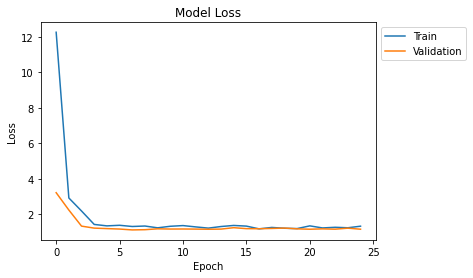

In [30]:
# Summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

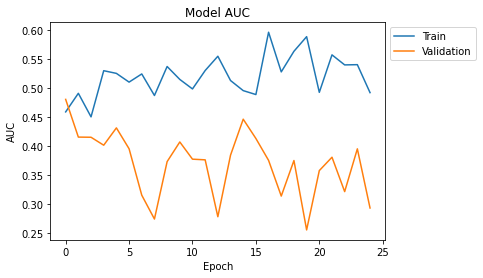

In [32]:
# Summarize history for loss

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()